In [13]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from deepchem.molnet import load_hiv, load_tox21, load_bace_classification, load_sider, load_clintox, load_bbbp
from hdpy.metrics import compute_roc_enrichment
import seaborn as sns
sns.set_style("whitegrid")


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

from tqdm import tqdm
from pathlib import Path

RANDOM_SEED=5
output_result_dir = Path(f"/p/vast1/jones289/hd_results/{RANDOM_SEED}")

green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
red_color_pal = sns.color_palette("Reds", 10)
purple_color_pal = sns.color_palette("Purples", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

plot_dict = {
    "RPFP": ("HDB-RPFP", red_color_pal[4]),
    "Combo": ("HDB-Combo", purple_color_pal[5]),
            #   "HDBind (10k) (GPU-no encode)": green_color_pal[8],
              "MoLFormer": ("HDB-MoLFormer", green_color_pal[7]),
              # "MoLFormer+RPFP": ("HDB Combo", green_color_pal[9]),
              "MolCLR": ("HDB-MolCLR", green_color_pal[4]),
              "DECFP-4": ("HDB-DECFP", red_color_pal[8]),
              "MLP": ("MLP", "black"),
    }


model_name_map = {
    "hdbind-molformer-decfp-combo-1k": "HDB-Combo",
    "hdbind-molformer-decfp-combo-100k": "HDB-Combo",
    "hdbind-molformer-decfp-combo-1m": "HDB-Combo",
    "hdbind-molformer-decfp-combo": "HDB-Combo",
    "hdbind-rp-ecfp-1024-1-1k": "HDB-RPFP",
    "hdbind-rp-ecfp-1024-1": "HDB-RPFP",
    "hdbind-rp-ecfp-1024-1-100k": "HDB-RPFP",
    "hdbind-rp-ecfp-1024-1-1m": "HDB-RPFP",
    "hdbind-rp-molformer-1k": "HDB-MoLFormer",
    "hdbind-rp-molformer": "HDB-MoLFormer",
    "hdbind-rp-molformer-100k": "HDB-MoLFormer",
    "hdbind-rp-molformer-1m": "HDB-MoLFormer",
    "hdbind-rp-molclr-1k": "HDB-MolCLR",
    "hdbind-rp-molclr": "HDB-MolCLR",
    "hdbind-rp-molclr-100k": "HDB-MolCLR",
    "hdbind-rp-molclr-1m": "HDB-MolCLR",
    "hdbind-directecfp-1k-1": "HDB-DECFP",
    "hdbind-directecfp-1k-2": "HDB-DECFP",
    "hdbind-directecfp-1k-4": "HDB-DECFP",
    "hdbind-directecfp-10k-1": "HDB-DECFP",
    "hdbind-directecfp-10k-2": "HDB-DECFP",
    "hdbind-directecfp-10k-4": "HDB-DECFP",
    "hdbind-directecfp-100k-1": "HDB-DECFP",
    "hdbind-directecfp-100k-2": "HDB-DECFP",
    "hdbind-directecfp-100k-4": "HDB-DECFP",
    "hdbind-directecfp-1m-1": "HDB-DECFP",
    "hdbind-directecfp-1m-2": "HDB-DECFP",
    "hdbind-directecfp-1m-4": "HDB-DECFP",
    "mlp-1024-1": "MLP-1024",
    "mlp-2048-1": "MLP-2048"
}

In [14]:
# model_dict = {
#     "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
#     # "hdbind-rp-ecfp-1024-1-100": ("HDB-ECFP-100", green_color_pal[3]),
#     # "hdbind-rp-ecfp-1024-1-1k": ("HDB-ECFP-1k", green_color_pal[3]),
#     "hdbind-rp-ecfp-1024-1": ("HDB-RPFP", green_color_pal[3]),
#     # "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[3]),
#     # "hdbind-rp-ecfp-1024-1-1m": ("HDB-ECFP-1m", green_color_pal[3]),
#     # "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[3]),
#     # "hdbind-rp-molclr-100":  ("HDB-MolCLR-100", green_color_pal[7]),
#     # "hdbind-rp-molclr-1k":  ("HDB-MolCLR-1k", green_color_pal[7]),
#     "hdbind-rp-molclr":  ("HDB-MolCLR", green_color_pal[7]),
#     # "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[7]),
#     # "hdbind-rp-molclr-1m":  ("HDB-MolCLR-1m", green_color_pal[7]),
#     # "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[7]),
#     # "hdbind-rp-molformer-100": ("HDB-MolFormer-100", green_color_pal[7]),
#     # "hdbind-rp-molformer-1k": ("HDB-MolFormer-1k", green_color_pal[7]),
#     "hdbind-rp-molformer": ("HDB-MolFormer", green_color_pal[7]),
#     # "hdbind-rp-molformer-100k": ("HDB-MolFormer-100k", green_color_pal[7]),
#     # "hdbind-rp-molformer-1m": ("HDB-MolFormer-1m", green_color_pal[7]),
#     "hdbind-rp-molformer-ecfp-combo": ("HDB-Combo", green_color_pal[7]),
#     # "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[3]),
#     # "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[3]),
#     # "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[3]), 
#     # "hdbind-directecfp-100-1": ("HDB-DECFP-100-1", green_color_pal[3]),
#     # "hdbind-directecfp-100-2": ("HDB-DECFP-100-2", green_color_pal[3]),
#     # "hdbind-directecfp-100-4": ("HDB-DECFP-100-4", green_color_pal[3]),
#     # "hdbind-directecfp-1k-1": ("HDB-DECFP-1k-1", green_color_pal[3]),
#     # "hdbind-directecfp-1k-2": ("HDB-DECFP-1k-2", green_color_pal[3]),
#     # "hdbind-directecfp-1k-4": ("HDB-DECFP-1k-4", green_color_pal[3]),
#     # "hdbind-directecfp-10k-1": ("HDB-DECFP-10k-1", green_color_pal[3]),
#     # "hdbind-directecfp-10k-2": ("HDB-DECFP-10k-2", green_color_pal[3]),
#     "hdbind-directecfp-10k-4": ("HDB-DECFP", green_color_pal[3]),
#     # "hdbind-directecfp-100k-1": ("HDB-DECFP-100k-1", green_color_pal[3]),
#     # "hdbind-directecfp-100k-2": ("HDB-DECFP-100k-2", green_color_pal[3]),
#     # "hdbind-directecfp-100k-4": ("HDB-DECFP-100k-4", green_color_pal[3]),
#     # "hdbind-directecfp-1m-1": ("HDB-DECFP-1m-1", green_color_pal[3]),
#     # "hdbind-directecfp-1m-2": ("HDB-DECFP-1m-2", green_color_pal[3]),
#     # "hdbind-directecfp-1m-4": ("HDB-DECFP-1m-4", green_color_pal[3]),
#     # "hdbind-molformer-decfp-combo-1k": ("HDB-Combo-1k", purple_color_pal[9]),
#     "hdbind-molformer-decfp-combo": ("HDB-Combo", green_color_pal[9]),
#     # "hdbind-molformer-decfp-combo-100k": ("HDB-Combo-100k", green_color_pal[9]),
#     # "hdbind-molformer-decfp-combo-1m": ("HDB-Combo-1m", green_color_pal[9]),
#     "mlp-1024-1": ("MLP", blue_color_pal[7]),
#     "Vina": ("Vina", "salmon"),
# }


In [15]:
sns.__version__

'0.13.2'

In [16]:
def collect_roc_metrics(dataset:str, split:str, config_list:list):

    result_dict = {"model": [],
                   "D": [],
                   "seed": [],
                   "roc-auc": [],
                   "er-1": []
                   }

    target_list = []
    if dataset in ["bbbp", "tox21", "clintox", "hiv", "bace", "sider"]:
        if dataset == "bbbp":
            data = load_bbbp()
        if dataset == "tox21":
            data = load_tox21()
        if dataset == "clintox":
            data = load_clintox(splitter="scaffold")
        if dataset == "hiv":
            data = load_hiv()
        if dataset == "bace":
            data = load_bace_classification()
        if dataset == "sider":
            data = load_sider()

        target_list = data[0]
    elif dataset == "lit-pcba":
        lit_pcba_ave_p = Path("/p/vast1/jones289/lit_pcba/AVE_unbiased")
        target_list = [x.name for x in list(lit_pcba_ave_p.glob("*/"))]

    # print(target_list)
    for config_path in tqdm(config_list):
        print(config_path)
        exp_name = config_path.stem
        # for d in range(10):
        for target_name in target_list:
            
            result_file = Path(
                f"{output_result_dir}/{exp_name}.{dataset}-{target_name.replace(' ','_')}-{split}.{RANDOM_SEED}.pkl"
            )
            try:
                data = torch.load(result_file)
            except FileNotFoundError as e:
                print(f"{e}. {result_file} does not exist.")

            for random_state in data["trials"].keys():
                result_dict["model"].append(model_name_map[exp_name])
                result_dict["D"].append(data["args"].D)
                result_dict["seed"].append(random_state)
                result_dict["roc-auc"].append(data["trials"][random_state]["roc-auc"])

                try:
                    
                    er_1 = data["trials"][random_state]["er-1"]
                    result_dict["er-1"].append(er_1)

                except KeyError as e:
            
                    print(f"{e}. result missing roc-enrichment metrics. computing these now.")
                    for trial_idx in data["trials"].keys():
                        scores = None 
                        
                        if "er-1" not in data["trials"][trial_idx].keys():

                            # if config.model in ["molehd-bpe", "selfies","hdbind-directecfp-10k-4",
                                                # "hdbind-molformer-decfp-combo",
                                                #   "ecfp", "rp", "directecfp"]:
                                # scores = model_data_dict["trials"][trial_idx]["eta"]
                            if "mlp" in exp_name.lower():
                                scores = data["trials"][trial_idx]["eta"][:, 1]
                            else:

                                scores = data["trials"][trial_idx]["eta"]
                            
                            labels = data["trials"][trial_idx]['y_true']

                            trial_er_1 = compute_roc_enrichment(scores=scores, labels=labels, fpr_thresh=.01)

                            data["trials"][trial_idx]["er-1"] = trial_er_1
            

 
                    er_1 = data["trials"][random_state]["er-1"]
                    result_dict["er-1"].append(er_1)

    return pd.DataFrame(result_dict)

In [17]:
ave_metric_df = collect_roc_metrics(dataset="lit-pcba", split="ave", config_list=list(Path("/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs").glob("*.yml")))

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1.yml


  3%|▎         | 1/30 [00:02<01:13,  2.54s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer-100k.yml


  7%|▋         | 2/30 [00:06<01:39,  3.55s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer-1k.yml


 10%|█         | 3/30 [00:08<01:18,  2.92s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer-1m.yml


 13%|█▎        | 4/30 [00:34<05:05, 11.73s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer.yml


 17%|█▋        | 5/30 [00:36<03:29,  8.37s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo-100k.yml


 20%|██        | 6/30 [00:40<02:45,  6.89s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc

 23%|██▎       | 7/30 [00:43<02:11,  5.70s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo-1m.yml


 27%|██▋       | 8/30 [00:56<02:53,  7.88s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo.yml


 30%|███       | 9/30 [00:58<02:08,  6.13s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-100k-1.yml


 33%|███▎      | 10/30 [01:01<01:43,  5.18s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-100k-2.yml


 37%|███▋      | 11/30 [01:05<01:28,  4.64s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-100k-4.yml


 40%|████      | 12/30 [01:09<01:19,  4.40s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-10k-1.yml


 43%|████▎     | 13/30 [01:11<01:04,  3.78s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-10k-2.yml


 47%|████▋     | 14/30 [01:13<00:53,  3.36s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-10k-4.yml


 50%|█████     | 15/30 [01:16<00:46,  3.09s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1k-1.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichme

 53%|█████▎    | 16/30 [01:19<00:44,  3.16s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1k-2.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichme

 57%|█████▋    | 17/30 [01:22<00:41,  3.18s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1k-4.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichme

 60%|██████    | 18/30 [01:26<00:38,  3.19s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1m-1.yml


 63%|██████▎   | 19/30 [01:38<01:04,  5.90s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1m-2.yml


 67%|██████▋   | 20/30 [01:50<01:19,  7.95s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1m-4.yml


 70%|███████   | 21/30 [02:04<01:26,  9.66s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1-100k.yml


 73%|███████▎  | 22/30 [02:09<01:05,  8.13s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrich

 77%|███████▋  | 23/30 [02:12<00:47,  6.75s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1-1m.yml


 80%|████████  | 24/30 [02:36<01:10, 11.82s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr-100k.yml


 83%|████████▎ | 25/30 [02:40<00:47,  9.48s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment 

 87%|████████▋ | 26/30 [02:43<00:30,  7.57s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr-1m.yml


 90%|█████████ | 27/30 [03:08<00:38, 12.76s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr.yml


 93%|█████████▎| 28/30 [03:10<00:19,  9.71s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/mlp-1024-1.yml


100%|██████████| 30/30 [03:13<00:00,  6.44s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/mlp-2048-1.yml
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-FEN1-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-FE

In [18]:
random_metric_df = collect_roc_metrics(dataset="lit-pcba", split="random", config_list=list(Path("/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs").glob("*.yml")))

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1.yml


  3%|▎         | 1/30 [00:02<01:14,  2.56s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer-100k.yml


  7%|▋         | 2/30 [00:06<01:40,  3.58s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichme

 10%|█         | 3/30 [00:10<01:35,  3.55s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer-1m.yml


 13%|█▎        | 4/30 [00:35<05:13, 12.06s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molformer.yml


 17%|█▋        | 5/30 [00:38<03:35,  8.64s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo-100k.yml


 20%|██        | 6/30 [00:42<02:51,  7.14s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc

 23%|██▎       | 7/30 [00:45<02:15,  5.87s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo-1m.yml


 27%|██▋       | 8/30 [00:58<03:00,  8.21s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-molformer-decfp-combo.yml


 30%|███       | 9/30 [01:01<02:17,  6.57s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-100k-1.yml


 33%|███▎      | 10/30 [01:04<01:49,  5.50s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-100k-2.yml


 37%|███▋      | 11/30 [01:08<01:31,  4.84s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-100k-4.yml


 40%|████      | 12/30 [01:11<01:20,  4.45s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-10k-1.yml


 43%|████▎     | 13/30 [01:14<01:04,  3.82s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-10k-2.yml


 47%|████▋     | 14/30 [01:16<00:54,  3.39s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-10k-4.yml


 50%|█████     | 15/30 [01:18<00:46,  3.09s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1k-1.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichme

 53%|█████▎    | 16/30 [01:22<00:44,  3.18s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1k-2.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichme

 57%|█████▋    | 17/30 [01:25<00:42,  3.25s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1k-4.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichme

 60%|██████    | 18/30 [01:29<00:39,  3.31s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1m-1.yml


 63%|██████▎   | 19/30 [01:41<01:06,  6.02s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1m-2.yml


 67%|██████▋   | 20/30 [01:53<01:19,  7.96s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-directecfp-1m-4.yml


 70%|███████   | 21/30 [02:05<01:20,  8.97s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1-100k.yml


 73%|███████▎  | 22/30 [02:08<00:57,  7.25s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrich

 77%|███████▋  | 23/30 [02:11<00:41,  5.91s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-ecfp-1024-1-1m.yml


 80%|████████  | 24/30 [02:29<00:57,  9.56s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr-100k.yml


 83%|████████▎ | 25/30 [02:32<00:37,  7.59s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment 

 87%|████████▋ | 26/30 [02:35<00:24,  6.17s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr-1m.yml


 90%|█████████ | 27/30 [02:52<00:28,  9.42s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/hdbind-rp-molclr.yml


 93%|█████████▎| 28/30 [02:53<00:14,  7.10s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/mlp-1024-1.yml


100%|██████████| 30/30 [02:55<00:00,  5.84s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs/mlp-2048-1.yml
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-FEN1-random.5.pkl'. /p/vast1/jones289/hd_resul

In [19]:
random_metric_df

,model,D,seed,roc-auc,er-1
0,HDB-RPFP,10000,0,0.801561,50.000000
1,HDB-RPFP,10000,1,0.798270,25.000000
2,HDB-RPFP,10000,2,0.796849,25.000000
3,HDB-RPFP,10000,3,0.797068,25.000000
4,HDB-RPFP,10000,4,0.801267,25.000000
...,...,...,...,...,...
4420,MLP-2048,10000,5,0.833841,36.746988
4421,MLP-2048,10000,6,0.844265,36.746988
4422,MLP-2048,10000,7,0.839351,35.542169
4423,MLP-2048,10000,8,0.840733,37.951807


In [20]:
mlp_1024_mean_rocauc_random = (random_metric_df[random_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).mean()["roc-auc"].values

mlp_1024_mean_rocauc_ave = (ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).mean()["roc-auc"].values

In [21]:
pd.__version__

'1.4.0'

In [36]:
model_dict = {
    "MoleHD-BPE": rocket_color_pal[4],
    "HDB-RPFP": green_color_pal[0],
    "HDB-DECFP": green_color_pal[3],
    "HDB-MolCLR": green_color_pal[5],
    "HDB-MoLFormer": green_color_pal[7],
    "HDB-Combo": green_color_pal[9],
    "MLP": blue_color_pal[7],
    # "Vina": ("Vina", "salmon"),
}

model_order_dict = {
    "HDB-RPFP": 0,
    "HDB-DECFP": 1,
    "HDB-MolCLR": 2,
    "HDB-MoLFormer": 3,
    "HDB-Combo": 4}



def make_plot(df, ax, metric):
    # print(df.head())
    df = df.sort_values(by='model', key=lambda x: x.map(model_order_dict))

    width=0.8
    gap=0.2

    sns.boxenplot(data=df, 
            x="D", y=metric, 
            hue="model", 
            ax=ax,
            # order=model_order_list,
            palette={x: model_dict[x] for x in model_dict.keys()},
            width=width, 
            gap=gap
            )
    
def make_roc_auc_plot():
    f,ax = plt.subplots(2,1, figsize=(16,20), sharex=True, sharey=True)

    make_plot(df=random_metric_df[random_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax[0], metric="roc-auc")

    make_plot(df=ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax[1], metric="roc-auc")
    ax[0].set_ylabel("ROC-AUC")
    ax[1].set_ylabel("")

    ax[0].set_title("Random", fontsize=18)
    ax[1].set_title("AVE", fontsize=18)

    alpha=0.7
    handles, labels = ax[0].get_legend_handles_labels()
    handles.append(ax[0].axhline(mlp_1024_mean_rocauc_random, color="red", linestyle="--", alpha=alpha))
    labels.append("MLP ($\mu$)")
    # ax[0].legend(handles,labels, fontsize="x-large", loc="best")
    ax[0].get_legend().remove()

    handles, labels = ax[1].get_legend_handles_labels()
    handles.append(ax[1].axhline(mlp_1024_mean_rocauc_ave, color="red", linestyle="--", alpha=alpha))
    labels.append("MLP ($\mu$)")
    ax[1].legend(handles,labels, fontsize="x-large", loc="best")
    ax[0].set_xlabel("HDC Dimension $D$", fontsize=20)
    ax[1].set_xlabel("HDC Dimension $D$", fontsize=20)

    plt.tight_layout()
    plt.savefig("lit-pcba-rocauc-boxenplot.png", dpi=450)
    
def make_er1_plot():
    f,ax = plt.subplots(1,1, figsize=(16,8), sharex=True, sharey=True)


    make_plot(df=ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax, metric="er-1")
    ax.set_ylabel("")

    ax.set_title("AVE", fontsize=18)

    alpha=0.7
    handles, labels = ax.get_legend_handles_labels()
    handles.append(ax.axhline(4.78, color="red", linestyle="--", alpha=alpha))
    labels.append("GRIM ($\mu$)")
    handles.append(ax.axhline(3.46, color="darkred", linestyle="-.", alpha=alpha))
    labels.append("Pafnucy ($\mu$)")

    ax.legend(handles,labels, fontsize="x-large", loc="best")
    ax.set_xlabel("HDC Dimension $D$", fontsize=20)

    plt.tight_layout()
    plt.savefig("lit-pcba-er1-boxenplot.png", dpi=450)

In [37]:
# make_roc_auc_plot()

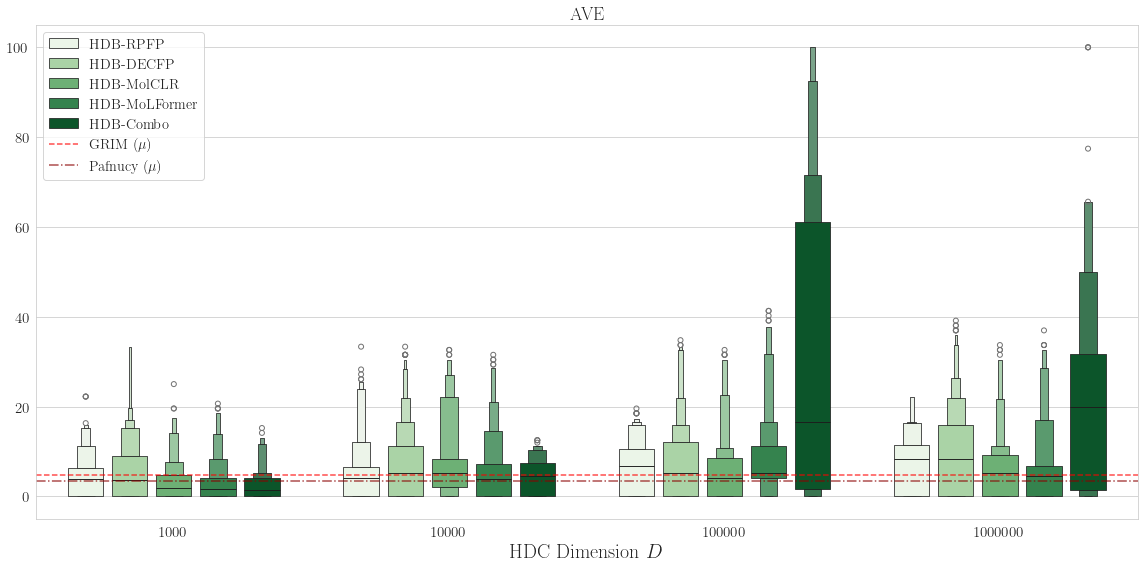

In [38]:
make_er1_plot()